In [267]:
# imports
import tueplots
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [301]:
plt.rcParams.update(tueplots.bundles.neurips2022(usetex=False))

In [268]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "r3tj863o"


In [269]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [270]:
summary_list, config_list, name_list, sigmas = [], [], [], []
filename = f"moebius_sweep_data_{SWEEP_ID}.csv"
if not isfile(filename):
    for run in sweep_runs:

        if (run.state == 'finished' or ('decoder_var' in run.config.keys() and run.config['decoder_var']>= 0.1)) and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files
            summary_list.append(run.summary._json_dict)



            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append(
                {k: v for k,v in run.config.items()
                 if not k.startswith('_')})

            sigmas.append(run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(config_list[-1]['latent_dim'])]).iloc[-1].to_numpy()[1:])


            # .name is the human-readable name of the run.
            name_list.append(run.name)



    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "sigmas" : sigmas
        })

    runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [293]:
runs_df

,summary,config,name,sigmas
0,"{'Metrics/train/neg_elbo': 2801.891357421875, ...","{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",smooth-sweep-300,"[1.2272353799858138e-08, 1.3331804105121137e-0..."
1,{'gradients/model.conditioner.fc.0.bias': {'_t...,"{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",wobbly-sweep-299,"[1.0328074395715703e-08, 7.71530572762913e-09,..."
2,{'gradients/model.encoder.fc.2.weight': {'_typ...,"{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",devoted-sweep-298,"[1.4725903163537168e-08, 2.3347576316723462e-0..."
3,{'gradients/model.decoder.fc.0.bias': {'_type'...,"{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",jumping-sweep-297,"[2.460499537448868e-08, 2.4236886275730285e-08..."
4,{'gradients/model.decoder.fc.0.bias': {'_type'...,"{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",legendary-sweep-296,"[1.1499972529804836e-08, 1.2867272580763256e-0..."
...,...,...,...,...
237,{'gradients/model.decoder.fc.2.weight': {'_typ...,"{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",peach-sweep-16,"[3.1019680500030518, 3.0485482215881348, 3.055..."
238,"{'_runtime': 2364, 'Metrics/val/neg_elbo': -0....","{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",expert-sweep-17,"[3.046877384185791, 2.988506317138672, 3.09199..."
239,"{'Metrics/val/rec_loss': 0.43881016969680786, ...","{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",bumbling-sweep-15,"[0.8598524332046509, 0.40231236815452576]"
240,{'gradients/model.decoder.fc.0.bias': {'values...,"{'lr': 0.0001, 'beta': 1, 'dims': 'None', 'see...",lilac-sweep-5,"[3.0052490234375, 3.1123147010803223]"


In [263]:
len(runs_df)

242

In [272]:
data = [ (summary['Metrics/val/mcc'], summary['Metrics/val/cima'], config['latent_dim'], config['decoder_var'], config['model.prior'],summary['Metrics/val/col_norms'], sigma) for summary, config, sigma in zip(runs_df['summary'], runs_df['config'], runs_df['sigmas'])]

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [273]:
len(data)

242

In [274]:
gamma_sq = [np.array(1./d[3]) for d in data]
prior = [d[4] for d in data]
col_norm_sq = [np.power(d[5],2) for d in data]
sigmas = runs_df.sigmas.to_numpy()
mcc = np.array([d[0] for d in data])
cima = np.array([d[1] for d in data])
dim = np.array([d[2] for d in data])

In [275]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

In [276]:
def lhs_rhs(col_norm_squared, priors, variances, gamma_squared, ext_gamma_squared, prior_name):
    lhs = [s for s,p in zip(variances,priors) if p == prior_name]
    rhs = [1./(float(prior_name=="gaussian")+g_sq*J_sq) for g_sq, J_sq, p in zip(gamma_squared, col_norm_squared, priors) if p == prior_name]
    gamma = np.array([g for g,p in zip(gamma_squared, priors) if p == prior_name])
    gamma_ext = np.concatenate([g for g,p in zip(ext_gamma_squared, priors) if p == prior_name])

    abs_diff = np.abs(np.concatenate(lhs)-np.concatenate(rhs))
    lhs_rhs_vs_gamma =[ np.array([d for d, g in zip(abs_diff, gamma_ext) if g==gamma_select]) for gamma_select in np.unique(gamma_ext)  ]

    return lhs, rhs, gamma_ext, gamma, abs_diff, lhs_rhs_vs_gamma

In [277]:
lhs_gauss ,rhs_gauss,gamma_gauss_ext,  gamma_gauss, abs_diff_gauss, lhs_rhs_vs_gamma_gauss = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq, ext_gamma_sq, "gaussian")
lhs_laplace ,rhs_laplace,gamma_laplace_ext, gamma_laplace,  abs_diff_laplace, lhs_rhs_vs_gamma_laplace = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"laplace")
lhs_uniform ,rhs_uniform,gamma_uniform_ext, gamma_uniform,  abs_diff_uniform, lhs_rhs_vs_gamma_uniform = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"uniform")

In [306]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

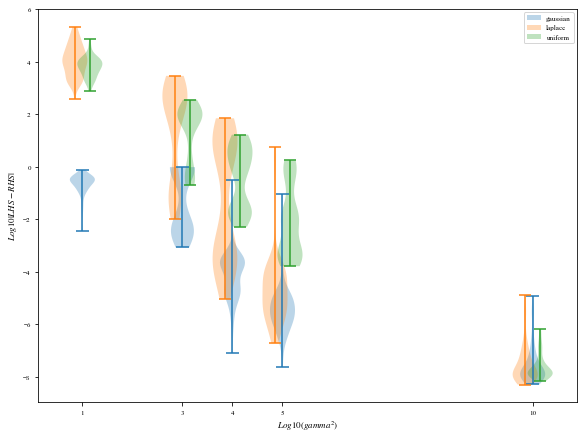

In [307]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)

In [280]:
def cima_mcc(cimas, mccs, dims, priors,  prior_name):
    cima = np.array([c for c,p in zip(cimas, priors) if p == prior_name])
    mcc = np.array([m for m,p in zip(mccs, priors) if p == prior_name])
    dim = np.array([d for d,p in zip(dims, priors) if p == prior_name])


    cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(dim)  ]
    mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(dim)  ]

    return cima, mcc, dim, cima_vs_dim, mcc_vs_dim

In [281]:
cima_gauss, mcc_gauss, dim_gauss, cima_vs_dim_gauss, mcc_vs_dim_gauss = cima_mcc(cima, mcc, dim, prior, "gaussian")
cima_laplace, mcc_laplace, dim_laplace, cima_vs_dim_laplace, mcc_vs_dim_laplace = cima_mcc(cima, mcc, dim, prior, "laplace")
cima_uniform, mcc_uniform, dim_uniform, cima_vs_dim_uniform, mcc_vs_dim_uniform = cima_mcc(cima, mcc, dim, prior, "uniform")

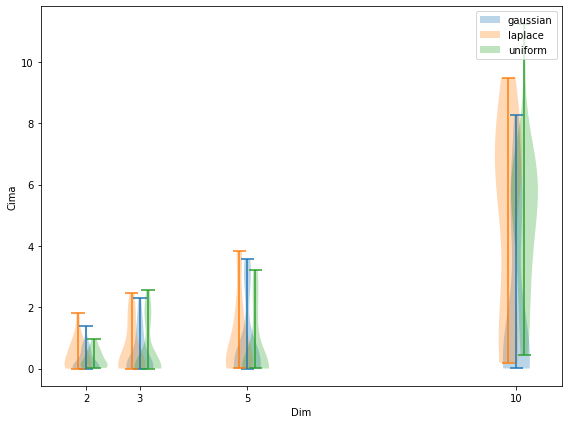

In [282]:
violin_by_prior(cima_vs_dim_gauss, cima_vs_dim_laplace, cima_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'cima_vs_dim')

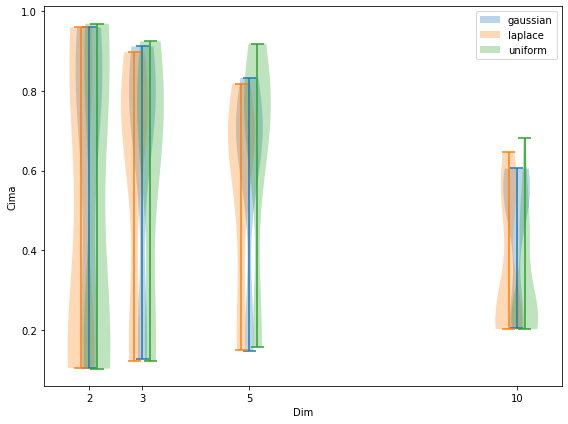

In [283]:
violin_by_prior(mcc_vs_dim_gauss, mcc_vs_dim_laplace, mcc_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'mcc_vs_dim')

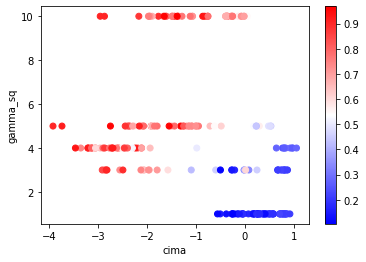

In [284]:
plt.scatter(np.log10(cima), np.log10(gamma_sq),c=mcc,cmap='bwr',)
plt.xlabel('cima')
plt.ylabel('gamma_sq')
plt.colorbar()

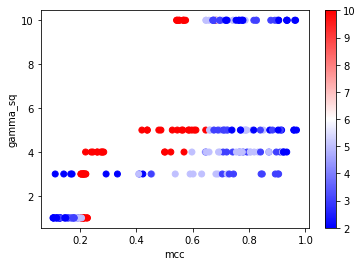

In [285]:
plt.scatter(mcc, np.log10(gamma_sq), c=dim,cmap='bwr',)
plt.xlabel('mcc')
plt.ylabel('gamma_sq')
plt.colorbar()

In [286]:
cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]
mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x124a94880>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x125751910>,
 'cmins': <matplotlib.collections.LineCollection at 0x124ccc4f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x124ccc520>}

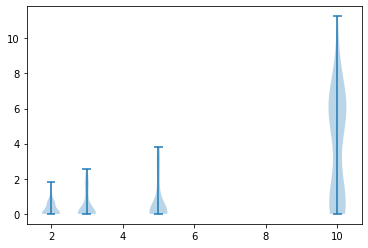

In [287]:
plt.violinplot(cima_vs_dim, positions=np.unique(np.array(dim)))

In [289]:
markers = ['o' if p=="gauss" else '^' if p=='laplace' else 's' for p in prior]

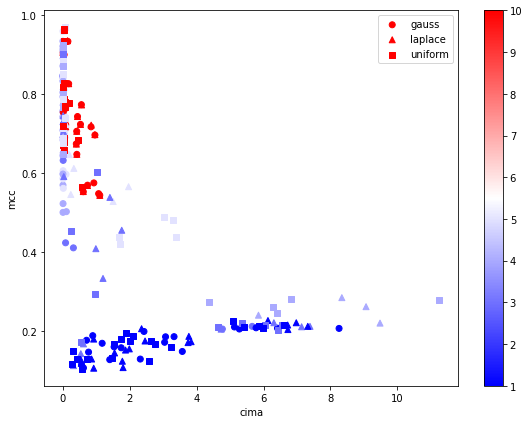

In [290]:
plt.figure(figsize=(8,6))
plt.scatter((cima_gauss),(mcc_gauss), c=np.log10(gamma_gauss),cmap='bwr', marker='o', label='gauss')
plt.scatter((cima_laplace),(mcc_laplace), c=np.log10(gamma_laplace),cmap='bwr', marker='^', label='laplace')
plt.scatter((cima_uniform),(mcc_uniform), c=np.log10(gamma_uniform),cmap='bwr', marker='s', label='uniform')
plt.xlabel("$cima$")
plt.ylabel("$mcc$")
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.savefig('cima_vs_mcc')